In [1]:
# Import necessary libraries
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
import random

# Check for CUDA availability and set device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")

# Function to create a clean pattern with multiple crosses and reduced thickness of 6
def create_clean_multi_cross(size=64, thickness=6):
    cross = np.zeros((size, size))
    mid = size // 2
    quarter = size // 4
    three_quarter = 3 * size // 4

    for pos in [quarter, mid, three_quarter]:
        cross[pos - thickness // 2:pos + thickness // 2, :] = 1
        cross[:, pos - thickness // 2:pos + thickness // 2] = 1
    return cross

# Function to add noise to an image
def diffuse_image(image, noise_level=0.5):
    return image * (1 - noise_level) + torch.randn_like(image) * noise_level

# Function to add noise to an image at multiple linear levels
def diffuse_image_levels_linear(image, levels):
    noise_levels = np.linspace(0, 1, levels)
    return [diffuse_image(image, noise_level) for noise_level in noise_levels]

def diffuse_image_levels_sigmoid(image, levels, k=0.1, offset=0.5):
    noise_levels = [1 / (1 + np.exp(-k * (i - offset * levels))) for i in range(levels)]
    return [diffuse_image(image, noise_level) for noise_level in noise_levels]


# Function to reconstruct an image step-by-step using the model
def reconstruct_image_stepwise(model, diffused_image_levels):
    reconstructed_image = diffused_image_levels[-1].clone().detach()
    for level_image in reversed(diffused_image_levels[:-1]):
        reconstructed_image = model(reconstructed_image).detach()
    return reconstructed_image

import torch
import torch.nn as nn

class StepwiseReverseDiffusionNet(nn.Module):
    def __init__(self):
        super(StepwiseReverseDiffusionNet, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Pooling layer
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  # Pooling layer
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=1, padding=1),
            #nn.Sigmoid()  # Moved to here for clarity
        )

    def forward(self, x):
        residual = x  # Store the initial input for the residual connection
        x = self.encoder(x)
        x = self.decoder(x)

        x = x + residual  # Adding residual term
        x = torch.sigmoid(x)  # Applying sigmoid activation
        return x

# Generate clean multi-cross patterns for the dataset with 1 sample
num_samples = 700
X_train_multi_clean = np.array([create_clean_multi_cross() for _ in range(num_samples)])
X_train_multi_clean = torch.tensor(X_train_multi_clean, dtype=torch.float32).unsqueeze(1).to(device)


# Generate diffused images at different linear levels (100 levels for this run)
levels = 100
diffused_images_levels_linear = [diffuse_image_levels_linear(img, levels) for img in X_train_multi_clean]
diffused_images_levels_linear = torch.cat([torch.stack(level) for level in zip(*diffused_images_levels_linear)], dim=0)
diffused_images_levels_linear = diffused_images_levels_linear.to(device)

# Initialize the neural network and optimizer
batch_size = 32
total_epochs = 100

# Flatten the original and diffused images and create pairs
flat_diffused = diffused_images_levels_linear.view(-1, 1, 64, 64)  # Flatten
pairs = [(flat_diffused[i], flat_diffused[i-1]) for i in range(1, flat_diffused.shape[0]) if i % 100 != 0]

# Separate the pairs into two lists: inputs (noisy) and targets (less noisy)
inputs, targets = zip(*pairs)
inputs = torch.stack(inputs)
targets = torch.stack(targets)

# Check their shapes
print(inputs.shape)
print(targets.shape)

# Create DataLoader for batching
train_dataset = TensorDataset(inputs, targets)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

model = StepwiseReverseDiffusionNet()
model = model.to(device)  # Move the model to the GPU
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Initialize list to store epoch-wise average losses
epoch_losses = []

# Training loop
for epoch in range(total_epochs):
    epoch_loss_sum = 0.0  # Initialize sum of losses for this epoch
    num_batches = 0  # Initialize count of batches

    for i, (original_images, diffused_images) in enumerate(train_loader):
        original_images, diffused_images = original_images.to(device), diffused_images.to(device)

        output = model(diffused_images)
        loss = nn.MSELoss()(output, original_images)
        #loss = nn.SmoothL1Loss()(output, original_images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss_sum += loss.item()  # Add the batch loss to the sum for this epoch
        num_batches += 1  # Increment the count of batches

    epoch_avg_loss = epoch_loss_sum / num_batches  # Calculate the average loss for this epoch
    epoch_losses.append(epoch_avg_loss)  # Append the average loss for this epoch

    print(f"Epoch [{epoch+1}/{total_epochs}], Average Loss: {epoch_avg_loss:.4f}")

CUDA is available. Using GPU.
torch.Size([69300, 1, 64, 64])
torch.Size([69300, 1, 64, 64])
Epoch [1/100], Average Loss: 0.3438
Epoch [2/100], Average Loss: 0.3406
Epoch [3/100], Average Loss: 0.3403
Epoch [4/100], Average Loss: 0.3401
Epoch [5/100], Average Loss: 0.3399
Epoch [6/100], Average Loss: 0.3398
Epoch [7/100], Average Loss: 0.3397
Epoch [8/100], Average Loss: 0.3396
Epoch [9/100], Average Loss: 0.3396
Epoch [10/100], Average Loss: 0.3396
Epoch [11/100], Average Loss: 0.3395
Epoch [12/100], Average Loss: 0.3395
Epoch [13/100], Average Loss: 0.3395
Epoch [14/100], Average Loss: 0.3394
Epoch [15/100], Average Loss: 0.3394
Epoch [16/100], Average Loss: 0.3394
Epoch [17/100], Average Loss: 0.3394
Epoch [18/100], Average Loss: 0.3394
Epoch [19/100], Average Loss: 0.3394
Epoch [20/100], Average Loss: 0.3393
Epoch [21/100], Average Loss: 0.3393
Epoch [22/100], Average Loss: 0.3393
Epoch [23/100], Average Loss: 0.3393
Epoch [24/100], Average Loss: 0.3393
Epoch [25/100], Average Loss:

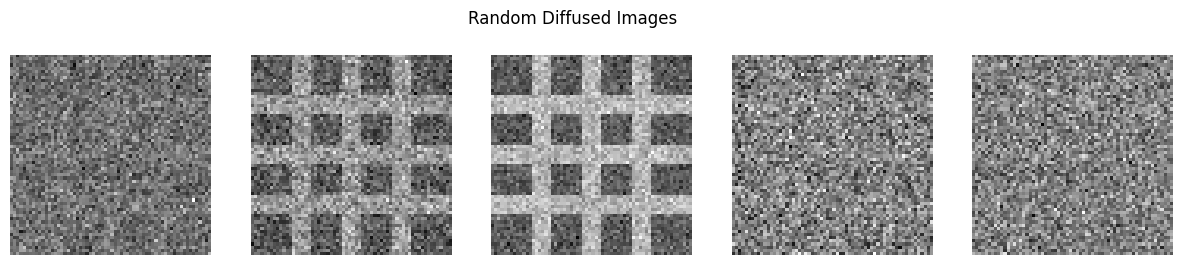

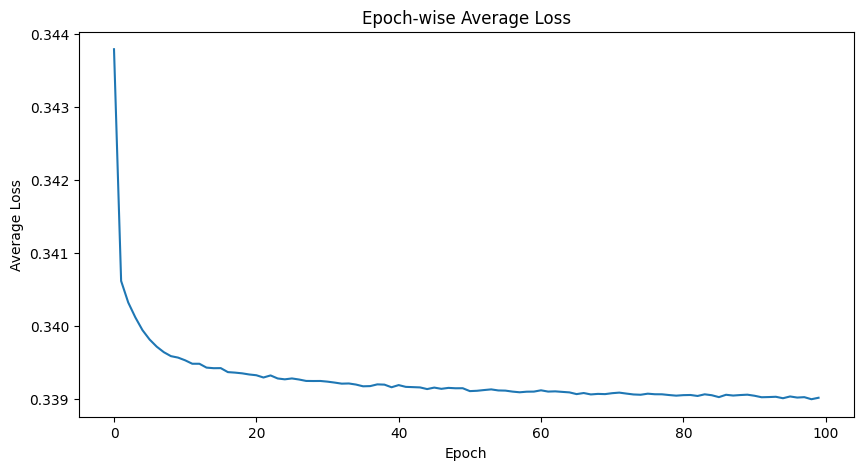

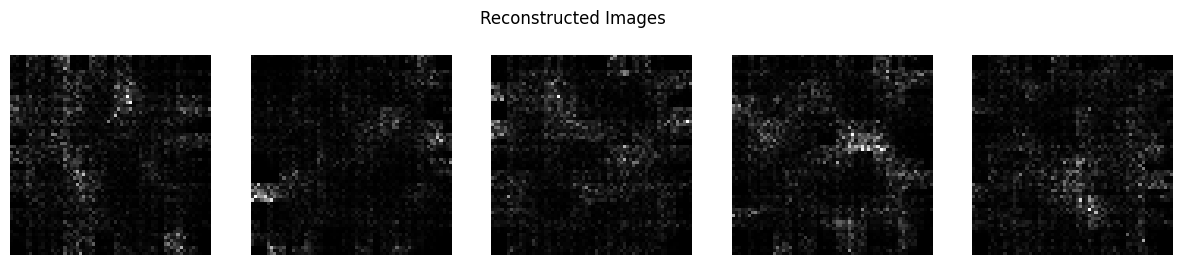

In [5]:
# Randomly pick 5 diffused images for visualization
random_indices = torch.randint(0, diffused_images_levels_linear.shape[0], (5,))

# Collect the randomly picked diffused images
random_diffused_images = [diffused_images_levels_linear[idx].squeeze().cpu().numpy() for idx in random_indices]

# Plot the random diffused images
plt.figure(figsize=(15, 3))
for i, img in enumerate(random_diffused_images, 1):
    plt.subplot(1, 5, i)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
plt.suptitle('Random Diffused Images')
plt.show()

# Plot the epoch-wise losses
plt.figure(figsize=(10, 5))
plt.plot(epoch_losses)
plt.title("Epoch-wise Average Loss")
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.show()

# Function to reconstruct an image iteratively using the model
def reconstruct_image_iteratively(model, initial_noisy_image, num_iterations):
    reconstructed_image = initial_noisy_image.clone().detach()
    for _ in range(num_iterations):
        reconstructed_image = model(reconstructed_image.unsqueeze(0)).squeeze()
    return reconstructed_image

'''if train_loader and train_dataset:
    del train_loader  # Delete DataLoader
    del train_dataset    # Delete Dataset
    torch.cuda.empty_cache()'''

# Generate 5 random noise inputs (similar to the noisiest level in your dataset)
initial_noisy_images = torch.randn(5, 1, 64, 64).to(device)  # Assuming the image shape is (1, 64, 64)

# Run inference and collect the reconstructed images
reconstructed_images = []
for initial_noisy_image in initial_noisy_images:
    reconstructed_image = reconstruct_image_iteratively(model, initial_noisy_image, 1)
    reconstructed_images.append(reconstructed_image.cpu().detach().numpy())

# Plot the reconstructed images
plt.figure(figsize=(15, 3))
for i, img in enumerate(reconstructed_images, 1):
    plt.subplot(1, 5, i)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.axis('off')
plt.suptitle('Reconstructed Images')
plt.show()